In [2]:
pip install gym torch numpy matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827622 sha256=8c82435c359e4a8099a0645b909867cadc9b77a47e5f5b231dbe8e8f058613dd
  Stored in directory: /Users/krishianjanlanka/Library/Caches/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


Episode 0, Total Reward: 12.0
Episode 100, Total Reward: 154.0
Episode 200, Total Reward: 119.0
Episode 300, Total Reward: 193.0
Episode 400, Total Reward: 500.0
Episode 500, Total Reward: 500.0
Episode 600, Total Reward: 500.0
Episode 700, Total Reward: 500.0
Episode 800, Total Reward: 500.0
Episode 900, Total Reward: 500.0


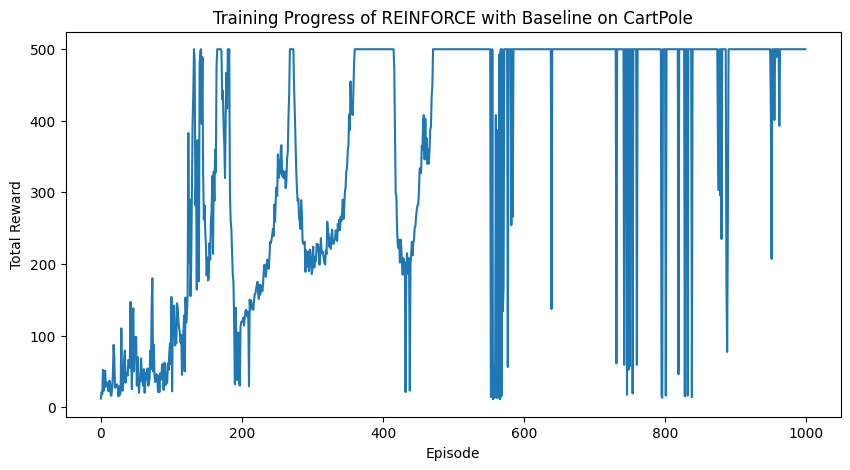


Training completed! Now showing the trained CartPole...

Evaluating trained policy...

Starting evaluation episode 1
Episode 1 finished with total reward: 500.0

Starting evaluation episode 2
Episode 2 finished with total reward: 500.0

Starting evaluation episode 3
Episode 3 finished with total reward: 500.0

Starting evaluation episode 4
Episode 4 finished with total reward: 500.0

Starting evaluation episode 5
Episode 5 finished with total reward: 500.0


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
# Change this line at the top of the code
import gymnasium as gym  # Using gymnasium instead of gym
# Improved hyperparameters
HIDDEN_UNITS = 32
LEARNING_RATE = 0.005
DISCOUNT_FACTOR = 0.99
MAX_EPISODES = 1000

# Set up the CartPole environment
env = gym.make("CartPole-v1", render_mode="human")
env.reset(seed=1)
env.action_space.seed(1)

# Set seeds for reproducibility
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

# Environment dimensions
state_dim = env.observation_space.shape[0]  # 4 for CartPole
action_dim = env.action_space.n  # 2 for CartPole actions (left, right)

# Define the improved Policy Network with baseline
class CartPolePolicy(nn.Module):
    def __init__(self, state_size, action_size, hidden_units=HIDDEN_UNITS):
        super(CartPolePolicy, self).__init__()
        # Shared feature extraction layer
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, hidden_units),
            nn.ReLU()
        )
        
        # Policy head (actor)
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, action_size)
        )
        
        # Value head (critic/baseline)
        self.value_head = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        action_logits = self.policy_head(features)
        action_probs = torch.softmax(action_logits, dim=-1)
        state_value = self.value_head(features)
        return action_probs, state_value

# Function to calculate discounted and normalized rewards
def calculate_discounted_rewards(reward_seq, gamma):
    discounted_rewards = np.zeros_like(reward_seq, dtype=np.float32)
    cumulative = 0.0
    for t in reversed(range(len(reward_seq))):
        cumulative = cumulative * gamma + reward_seq[t]
        discounted_rewards[t] = cumulative
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)
    return discounted_rewards

# Evaluation function
def evaluate_policy(policy_network, num_episodes=5):
    print("\nEvaluating trained policy...")
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0
        
        print(f"\nStarting evaluation episode {episode + 1}")
        
        while True:
            env.render()
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            
            with torch.no_grad():
                action_probs, _ = policy_network(state_tensor)
                action = torch.argmax(action_probs).item()
            
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            total_reward += reward
            state = next_state
            
            if done:
                print(f"Episode {episode + 1} finished with total reward: {total_reward}")
                break
    
    env.close()

# Instantiate the policy network and optimizer
policy_network = CartPolePolicy(state_dim, action_dim)
optimizer = optim.Adam(policy_network.parameters(), lr=LEARNING_RATE)

# Training loop
episode_rewards = []
total_reward_per_episode = []

for episode in range(MAX_EPISODES):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    log_probs = []
    values = []
    rewards = []
    total_episode_reward = 0
    
    while True:
        # Get action and value from network
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs, state_value = policy_network(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        
        # Sample action and get log probability
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        
        # Store log probability, value, and reward
        log_probs.append(log_prob)
        values.append(state_value)
        
        # Take step in environment
        step_result = env.step(action.item())
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        
        rewards.append(reward)
        total_episode_reward += reward
        state = next_state
        
        if done:
            break
    
    # Store total reward for plotting
    total_reward_per_episode.append(total_episode_reward)
    
    # Compute discounted rewards and convert to tensor
    discounted_rewards = calculate_discounted_rewards(rewards, DISCOUNT_FACTOR)
    discounted_rewards = torch.FloatTensor(discounted_rewards)
    
    # Convert values to tensor and detach from graph
    values = torch.cat(values).squeeze()
    
    # Compute advantages (discounted rewards - baseline)
    advantages = discounted_rewards - values.detach()
    
    # Calculate losses
    policy_loss = []
    value_loss = []
    
    for log_prob, advantage, value, reward in zip(log_probs, advantages, values, discounted_rewards):
        # Policy loss
        policy_loss.append(-log_prob * advantage)
        # Value loss (MSE)
        value_loss.append((value - reward) ** 2)
    
    # Combine losses
    policy_loss = torch.stack(policy_loss).sum()
    value_loss = torch.stack(value_loss).mean()
    total_loss = policy_loss + 0.5 * value_loss  # Value loss coefficient = 0.5
    
    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Print progress
    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_episode_reward}")

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(total_reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress of REINFORCE with Baseline on CartPole')
plt.show()

# Evaluate the trained policy
print("\nTraining completed! Now showing the trained CartPole...")
evaluate_policy(policy_network)

In [47]:
pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 1.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
